### Referencje
- [04 PyTorch tutorial - How do computational graphs and autograd in PyTorch work](https://www.youtube.com/watch?v=dEnUP6_kpeo)


In [1]:
import torch

In [2]:
from torchviz import make_dot  # do wizualizacji grafu obliczeń

# import może nie zadziałać, jeśli nie zainstalowano pakietu torchviz (najprawdopodobniej można go zainstalować za pomocą pip install graphviz oraz pip install torchviz)
# https://github.com/szagoruyko/pytorchviz

- [ ] graf obliczeń
- [ ] pochodna, pochodna cząstkowa, gradient
    - [ ] funkcja pythonowa licząca gradient z mnożenia wektorów i dodania skalara
    - [ ] to co wyzej dla wektora razy macierz
    - [ ] funkcja pythonowa licząca gradient z potęg macierzy
- [ ] propagacja wsteczna
- [ ] pochodna złożenia funkcji
- [ ] reguła łańcuchowa

- [ ] aproksymacja funkcji - funkcja straty
- [ ] gradient kierunkiem największego wzrostu
- [ ] spadek wzdłóż gradientu w poroblemach wypukłych - wizualizacja procesu
- [ ] optymalizacja - regresja liniowa
- [ ] pytorch
    - [ ] graf obliczeń wizualizacja
    - [ ] przechowywanie gradientów w pytorch
    - [ ] autograd
    - [ ] wytrenowanie parametrów w grafie obliczeń przez spadek wzdóż gradientu (dodawanie, mnożenie, wykładnik potęgi)

optymalizacja
autograd: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

## 1. Graf obliczeń

Obliczenia skłądające się na skomplikowaną funkcje niejednokronie możemy rozłożyć na prostsze kroki i ułatwić analizę przetwarzania wartości liczbowych dokonywanych przez skomplikowane funkcje.

Przykładowo, dla funkcji $f(x) = (x + 2)^2$ i ustalnoego $x$ obliczenia możemy rozłożyć na dwa kroki:
1. $g = x + 2$
2. $h = g^2$

Przedstwililiśmy funkcję $f(x)$ jako złożenie dwóch funkcji $g(x) = x + 2$ i $h(a) = g^2$ co oznacza, że użyliśmy wyniku jednej funkcji jako argumentu drugiej funkcji. W ten sposób możemy zdefiniować złożoną funkcję $f(x) = (h \circ g)(x) = f(g(x))$ dla $f(x) = (x + 2)^2$.

Zaprezentujmy powyższą funkcję w postaci grafu. Taki graf nazywamy grafem obliczeń (*eng. computational graph*).

# [OBRAZEK] Z PRZYKŁADOWYM GRAFEM OBLICZEŃ WPRZÓD 1

Ciąg obliczeń możemy rozłożyć na mniejsze kroki z różnym stopniem skomplikowania. W przypadku funkcji $f(x, y) = (x \cdot (2y + 1))^2 + y$ możemy rozłożyć ją na następujące kroki:
1. $g = x \cdot (2y + 1)$
2. $u = g^2 + y$

lub bardziej szczegółowo:

1. $p = 2y$
2. $q = p + 1$
3. $k = x \cdot q$
4. $l = k^2$
5. $u = l + y$

Zapiszmy jeszcze dla drugiego przypadku poszczególne funkcje które składają się na funkcję $f$:
- $p: \mathbb{R} \rightarrow \mathbb{R}, \; p(y) = 2y$
- $q: \mathbb{R} \rightarrow \mathbb{R}, \; q(p) = p + 1$
- $k: \mathbb{R^2} \rightarrow \mathbb{R}, \; k(x, q) = x \cdot q$
- $l: \mathbb{R} \rightarrow \mathbb{R}, \; l(k) = k^2$
- $u: \mathbb{R^2} \rightarrow \mathbb{R}, \; u(l, y) = l + y$

Zauważmy, że nie możemy zapisać funkcji $f$ jako złożenie funkcji $p, q, k, l, u$ ponieważ funkcje $k$ i $u$ przyjmują dwa argumenty, które nie są zwracana prze poprzedzające je funkcje. W takim przypadku możemy zdefiniować nasze funkcje pośrednie nieco inaczej tak aby przekazywały dalej wszystkie potrzebne do dalszych obliczeń argumenty.

Teraz rozłużmy funkcję $f$ na kolejne obliczenia tak aby można było ją zapisać jako złożenie kolejnych funkcji. W tym celu zdefiniujmy funkcje pośrednie następująco:
- $p: \mathbb{R^2} \rightarrow \mathbb{R^3}, \; p(x, y) = \mathbf{p} = (p_1, p_2, p_3) = (x, y, 2y)$
- $q: \mathbb{R^3} \rightarrow \mathbb{R^3}, \; q(p_1, p_2) = \mathbf{q} = (q_1, q_2, q_3) =  (p_1, p_2, p_3 + 1)$
- $k: \mathbb{R^3} \rightarrow \mathbb{R^2}, \; k(q_1, q_2, q_3) = \mathbf{k} = (k_1, k_2) = (q_2, q_1 \cdot q_3)$
- $l: \mathbb{R^2} \rightarrow \mathbb{R^2}, \; l(k_1, k_2) = \mathbf{l} = (l_1, l_2) = (k_1, k_2^2)$
- $u: \mathbb{R^2} \rightarrow \mathbb{R}, \; u(l_1, l_2) = l_1 + l_2$
Taki zapis wygląda co prawda bardziej skomplikowanie, ale pozwala na zapisanie funkcji $f$ jako złożenie funkcji $p, q, k, l, u$. Porównajmy oba zapisy korzystając z grafów obliczeń.

# [OBRAZEK] Z PRZYKŁADOWYM GRAFEM OBLICZEŃ WPRZÓD 2

Grafy obliczeń pozwalają na łatwiejsze zrozumienie złożonych obliczeń. Zauważmy jednak, że grafy te nie powinny mieć cykli, ponieważ wtedy wykonanie obliczeń nie byłoby możliwe.

# [OBRAZEK] Z PRZYKŁADOWYM GRAFEM OBLICZEŃ WPRZÓD 3

**Ćwiczenie 1**
Zapisać funkcję $f(x, y) = (3 x + y)^2 + y$ jako graf obliczeń.

**Ćwiczenie 2**
Zapisać graf obliczeń dla funkcji przyjmującej wektor $\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix}$ zdefiniowanej jako $f(\mathbf{x})$ przy ustalonym wektorze $\mathbf{a} = \begin{bmatrix} -3 \\ 2 \\ 0 \end{bmatrix}$. Podstaw w miejsce $x_1, x_2, x_3$ odpowiednio $-5, 11, 7$ i uzupełnij wartości w grafie obliczeń wynikami kalkulacji dla jego wierzchołków.

**Ćwiczenie 3**
Zapisać graf obliczeń dla funkcji $\sigma$ sigmoid (*eng. sigmoid*) zdefinowanej jako $\sigma(x) = \frac{1}{1 + e^{-x}}$.

**Ćwiczenie 4** Zapisać graf obliczeń dla funkcji tangens hiperboliczny $\tanh$ zdefinowanej jako $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ wyróżniając operacje: $e^x$, $e^{-x}, +, -, \frac{\cdot}{\cdot}$.

**Ćwiczenie 5**
Sprawdzić, że tangens hiperboliczny można przedstawić jako $\tanh(x) = \begin{bmatrix} 1 & -1\end{bmatrix} \times \sigma \left( x \cdot \begin{bmatrix} 2 \\ -2 \end{bmatrix} \right)$ gdzie $\cdot$ oznacza mnożenie wektora przez skalar, $\times$ mnożenie macierzy, a $\sigma$ funkcję sigmoid aplikowaną do każdego elementu wektora oddzielnie (*eng. element-wise*). Zapisz odpowiedni graf obliczeń.

**Ćwiczenie 6**
Zapisać graf obliczeń dla funkcji $f: \mathbb{R^3} \rightarrow \mathbb{R^2}$ zdefiniowanej jako $f(\mathbf{x}) = \sigma(\mathbf{W} \mathbf{x} + \mathbf{b})$ gdzie $\mathbf{W} = \begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \end{bmatrix}$ i $\mathbf{b} = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$, a $\sigma$ to funkcja sigmoid aplikowana dla każdego elementu wektora odzielnie (*eng. element-wise*).

### Graf obliczeń w `torch`

Pytorch automatycznie tworzy i przechowuje graf obliczeń dla każdego ciągu operacji wykonywanych na tensorach, dla których flaga `requires_grad` jest ustawiona na `True`.

Zobaczmy jak wygląda graf obliczeń dla funkcji $f: \mathbb{R^{3 \times 2}} \rightarrow \mathbb{R^{3 \times 1}}$ danej formułą $f(\mathbf{X}) = \sigma(\mathbf{X} \mathbf{W} + \mathbf{b})$ gdzie $\mathbf{X} \in \mathbb{R^{3 \times 2}}$, $\mathbf{W} \in \mathbb{R^{2 \times 1}}$, $\mathbf{b} \in \mathbb{R^{3 \times 1}}$ oraz $\sigma$ to funkcja sigmoid.

/tmp/ipykernel_4002/1730553245.py:3: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  X = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]], requires_grad=True)


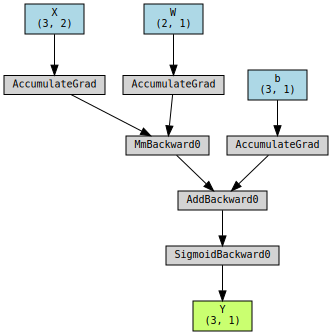

In [3]:
import torch.nn.functional as F

X = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]], requires_grad=True)
W = torch.tensor([[1.0], [2.0]], requires_grad=True)
b = torch.tensor([[1.0], [2.0], [3.0]], requires_grad=True)

Y = F.sigmoid(X @ W + b)
make_dot(Y, params={"X": X, "W": W, "b": b, "Y": Y})

Przyjżyjmy się notacji używanej na grafie obliczeń. Po pierwsze wyrżnijmy tensory wymagające obliczenia gradientu (`requires_grad=True`) oznaczone kolorami niebieskim i zielonym. Na grfie wyświetnale są ich nazwy ponieważ dodaliśmy dodatkowy arguement `params={"X": X, "W": W, "b": b, "Y": Y}`. Szare bloki oznaczają wyniki operacji przeprowadzanych na tensorach, którch wskazują na nie strzałkami. Powatarzające się operacje są numerowane w celu ich rozróżnienia (poza `AccumulateGrad`). Mamy do czynienia z następującymi wynikami operacji w danym wyżej grafie:
- `AccumulateGrad` - w odpowiednim rejestrze tensora przechowywane są wartości gradientów (zaraz dowiemy się lepiej czym są gradienty)
- `MmBackward0` - mnożenie macierzy
- `AddBackward0` - dodawanie macierzy
- `SigmoidBackward0` - zastosowanie funkcji sigmoid

Hmm. Dlaczego wyszstkie nazwy operacji kończą się na `Backward0`? `Backward0` oznacza, że jest to operacja związana z obliczaniem gradientów. Wszystkie operacje w Pytorch są zdefiniowane w taki sposób, że potrafią obliczać gradienty. W zasadzie właśnie dla tych gradientów interesujemy się grafem obliczeń. W tym celu Pytorch wykorzystuje mechanizmy automatycznej różniczkowania (*eng. automatic differentiation*). O tym jak to działa dowiemy się w kolejnym punkcie.

Warto zwrócić uwagę, że w Pytorch nie musimy definiować funkcji pośrednich tak jak w poprzednich przykładach. Wystarczy zdefiniować funkcję $f$ i Pytorch sam stworzy graf obliczeń. Być może nie robi to wrażenia dla tak prostego przypadku, dla którego graf obliczeń wynika wprost z zapisu obliczeń, ale wystarczy, że wykorzystamy interfejs Pytorch do zapisu nawet bardzo złożonego ciągu operacji matemetycznych będziemy automatycznie mieli dostęp do grafu obliczeń.

Być może nie wiadomo jeszcze po co właściwie jest nam ten cały graf obliczeń. W dalszej części notatnika zobaczymy, że graf obliczeń jest kluczowym elementem w procesie uczenia maszynowego, a w szczególności w procesie optymalizacji w uczeniu głębokim (*eng. deep learning*).

**Ćwiczenie 7**
Sprawdź co się stanie jeżeli pozmieniasz wartości flagi `requires_grad` dla tensorów $\mathbf{X}, \mathbf{W}, \mathbf{b}$. Jeżeli tensor nie posiada flagi `requires_grad` ustawionej na `True` to `torch` nie będzie przechowywał informacji o operacji `AccumulateGrad` dla tego tensora.

W poprzednim przykładzie zefiniowaliśmy jedną z możliwych formulacji tzw. warstwy (*eng. layer*) w sieci neuronowej (*eng. neural network*). Taką warstwę można określić jako warstwę liniową z funkcją aktywacji sigmoid (*eng. linear layer with sigmoid activation function*).

**Ćwiczenie 8**
Stwórz trzywarstwową sięc neuronową składając trzy warstwy liniowe z funkcją aktywacji sigmoid. Inczej mówiąc połącz ze sobą trzy warstwy liniowe z funkcją aktywacji sigmoid w taki sposób, że wyjście jednej warstwy jest wejściem dla kolejnej warstwy. Zapisz graf obliczeń dla takiej sieci neuronowej. Dodaj indeksowanie do nazw tzw. macierzy wag (*eng. weight matrices*) $\mathbf{W}$ i wektorów biasów (*eng. biases*) $\mathbf{b}$.

## 2. Pochoodna, pochodna cząstkowa, gradient 

Pochoodna (*eng. derivative*) funkcji jednej zmiennej rzeczywistej $f: \mathbb{R} \rightarrow \mathbb{R}$ w punkcie $x_0$ to granica ilorazu różnicowego funkcji $f$ w punkcie $x_0$:
$$f'(x_0) = \frac{df}{dx} (x_0) = \lim_{h \to 0} \frac{f(x_0 + h) - f(x_0)}{h}$$

Warto zwrócić uwagę, że jeżeli dany wyżej wzór nie daje sensownego wyniku to mówimy, że funkcja $f$ nie jest różniczkowalna w punkcie $x_0$. Wtedy pochodna funkcji $f$ w punkcie $x_0$ nie istnieje. Dla przykładu funkcja wartość bezwzględna (*eng. absolute value*) $f(x) = |x|$ nie jest różniczkowalna (*eng. differentiable*) w punkcie $x = 0$ ponieważ $\lim_{h \to 0^-} \frac{|0 + h| - |0|}{h} = -1$ oraz $\lim_{h \to 0^+} \frac{|h|}{h} = 1$, a więc granica lewostronna jest różna od prawostronnej i w konskekwencji pochodna nie istnieje. Dlatego jeżeli chcemy korzystać z pochodnych to musimy upewnić się, że funkcja jest różniczkowalna w punkcie, w którym chcemy obliczyć pochodną.


### Interpretacja geometryczna pochodnej

Pochodna funkcji jednej zmiennej rzeczywistej w punkcie $x_0$ to nachylenie stycznej do wykresu funkcji $f$ w punkcie $(x_0, f(x_0))$. Możemy mówić, że w takim razie pochodna pozwala lokalnie przybliżyć funkcję $f$ za pomocą funkcji liniowej. Wzór na równanie stycznej do wykresu funkcji $f$ w punkcie $(x_0, f(x_0))$ to:
$$y = f(x_0) + f'(x_0) (x - x_0)$$

**Ćwiczenie 9**
Znajdź z definicji pochodną funkcji $f(x) = x^2$ w punkcie $x_0 = 3$. Następnie narysuj wykres funkcji $f$ oraz styczną do wykresu funkcji $f$ w punkcie $(3, 9)$.

# OBRAZEK Z WYKRESEM FUNKCJI I STYCZNEJ - stopniowe zmniejszanie h

# OBRAZEK Z WYKRESEM FUNKCJI I STYCZNEJ - lupka wokół punktu

W `torch` do obliczania pochodnej funkcji jednej zmiennej rzeczywistej w punkcie możemy skorzystać z metody `backward` dla tensora, który przechowuje wartość funkcji. Obliczenie dla funkcji $f(x) = x^2$ w punkcie $x_0 = 3$ wygląda następująco:

```python
x = torch.tensor(3., requires_grad=True) # tensor z flagą requires_grad=True, kropka po 3 gwarantuje typ zmiennoprzecinkowy tensora (do osiągnięcia przez dtype=torch.float32)
f = x**2                                # obliczenie wartości funkcji
f.backward()                            # obliczenie pochodnej i zapisanie jej w x.grad
print(x.grad)                           # wyświetlenie pochodnej zapisanej w x.grad
```

**Ćwiczenie 10**
Dla funkcji $f(x) = \sin(x) + 2\sigma(x)^{x^3} - 3\ln(x) + 1$ narysuj graf obliczeń za pomocą `make_dot`. w punkcie $x_0 = 2$ wykorzystując `torch`, gdzie $\sigma$ to funkcja sigmoid, a $\ln$ logarytm naturalny. Aby wynik `make_dot` był czytelny zastosuj odpowiednie nazwy dla tensorów oraz wywołaj na niej `display()` aby wyświetlić graf obliczeń. Następnie oblicz pochodną funkcji $f$ w punkcie $x_0 = 2$.

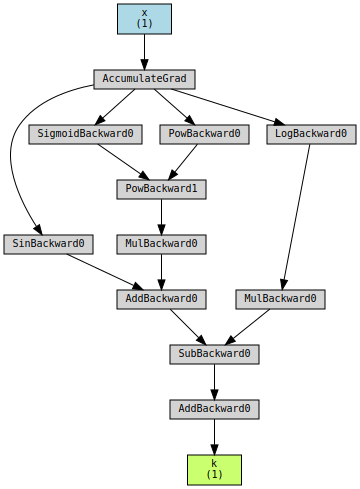

tensor([-2.3288])


In [12]:
# TODO - begin

# TODO - end

W poprzednim ćwiczeniu zobaczyliśmy, że pochodną można liczyć dla złożonych funkcji. Jak jednak `torch` radzi sobie z obliczaniem pochodnych dla tak na pozór nieprzyjemnych funkcji? Nie jest taki mądry jak się może wydawać. Korzysta po prostu z reguły łańcuchowej (*eng. chain rule*).

Pochodna złożenia funkcji (*eng. derivative of a composition of functions*) to pochodna funkcji złożonej $f(g(x))$ w punkcie $x_0$:
$$\frac{d}{dx} f(g(x)) (x_0) = f'(g(x_0)) \cdot g'(x_0)$$


Pochodna cząstkowa (*eng. partial derivative*) funkcji wielu zmiennych rzeczywistych $f: \mathbb{R^n} \rightarrow \mathbb{R}$ po zmiennej $x_i$ w punkcie $\mathbf{x}_0$ to granica ilorazu różnicowego funkcji $f$ w punkcie $\mathbf{x}_0$:
$$\frac{\partial f}{\partial x_i} (\mathbf{x}_0) = \lim_{h \to 0} \frac{f(\mathbf{x}_0 + h \mathbf{e}_i) - f(\mathbf{x}_0)}{h}$$
gdzie $\mathbf{e}_i$ to wektor jednostkowy w kierunku $i$-tej współrzędnej.